In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
import xgboost as xgb

In [83]:
data = pd.read_csv("./../Data/data.csv")
data.head()

,RHA_Year,Agricultural_use,Aquacultural_use,Availability,DBO5_contaminated,Domestic_use,DQO_contaminated,Industrial_use,Livestock_use,Multiple_use,PIB,Population_density,Public_urban_use,Rainfall,Runoff,Services_use,SST_contaminated,Temperature,Water_stress,Water_stress_lagged
0,Aguas del Valle de México_2006,4172.55,44.44,3009,72.0,4.24,88.0,344.53,9.29,239.56,25.500000,1146.296012,4262.29,793.25,1174,29.77,28.0,16.222949,154.28,119.11
1,Aguas del Valle de México_2007,4182.87,44.44,3008,68.0,4.24,76.0,343.23,9.29,242.67,24.726667,1153.928904,4270.94,827.00,1174,54.07,0.0,16.161932,155.10,154.28
2,Aguas del Valle de México_2008,4204.56,44.19,3514,68.0,4.23,72.0,367.56,8.41,240.24,24.726667,1168.301607,4209.37,726.25,1174,55.33,40.0,15.969565,132.31,155.10
3,Aguas del Valle de México_2009,4216.28,45.45,3513,75.0,5.09,83.4,267.65,7.52,329.01,24.660000,1175.090789,4208.67,724.00,1174,56.65,32.0,16.306480,132.58,132.31
4,Aguas del Valle de México_2010,4268.97,45.33,3515,66.7,5.14,74.1,276.16,7.52,339.78,24.320000,1205.153876,4230.28,819.00,1174,60.09,14.9,15.603830,133.89,132.58


In [84]:
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

In [85]:
X_train = train_data.drop(columns=["RHA_Year", "Water_stress"], axis=1)
y_train = train_data["Water_stress"]

## EDA

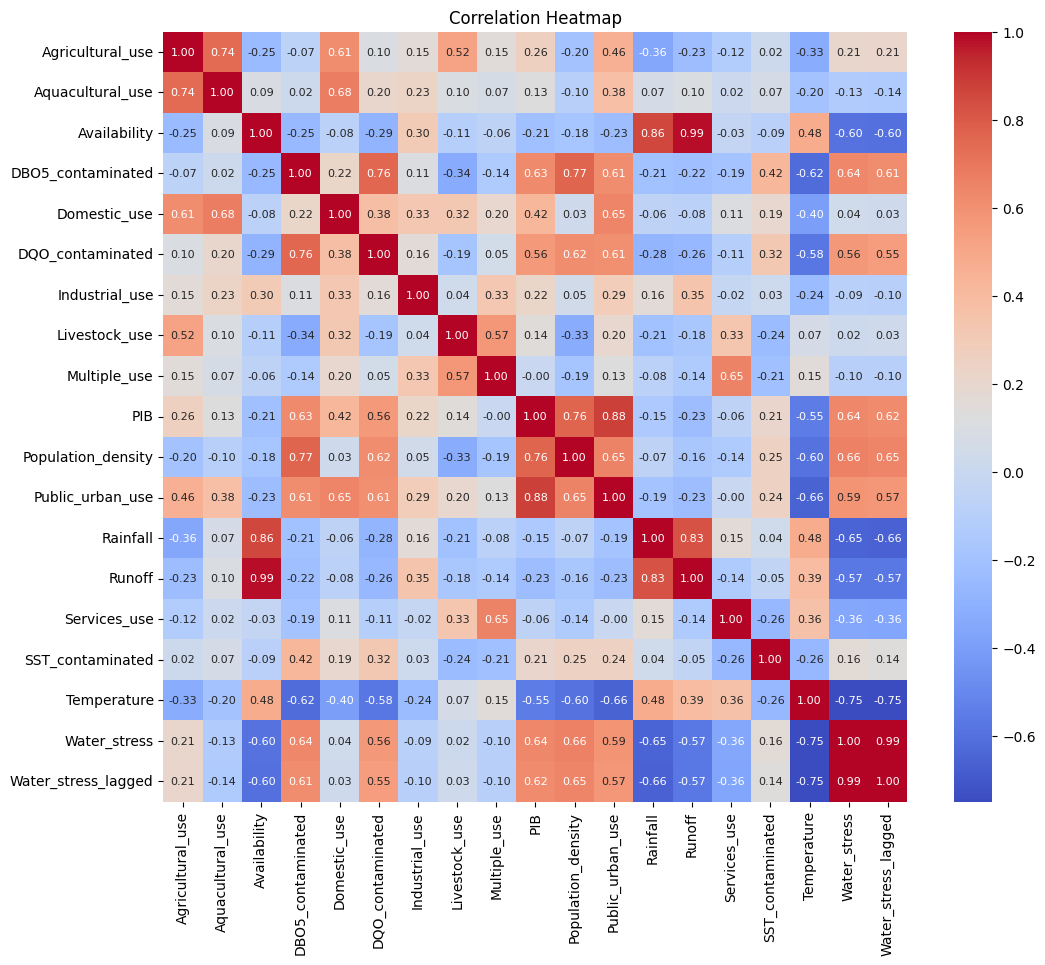

In [86]:
plt.figure(figsize=(12, 10))
correlation_matrix = train_data.corr(numeric_only=True)
sns.heatmap(
    correlation_matrix, annot=True, cmap="coolwarm", annot_kws={"size": 8}, fmt=".2f"
)
plt.title("Correlation Heatmap")
plt.show()

In [87]:
for column in X_train.columns:
    if column != "RHA_Year":
        fig = px.histogram(train_data, x=column, title=f"Histogram of {column}")
        fig.show()

In [88]:
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train)
lasso_coef = pd.Series(lasso.coef_, index=X_train.columns).sort_values(ascending=False)
print(f"LASSO Coefficients:\n{lasso_coef}")

LASSO Coefficients:
Population_density     0.042328
Public_urban_use       0.008115
Availability           0.000513
PIB                    0.000000
Multiple_use           0.000000
Temperature           -0.000000
SST_contaminated      -0.000000
Aquacultural_use      -0.000000
Water_stress_lagged    0.000000
Livestock_use          0.000000
Industrial_use        -0.000000
DQO_contaminated       0.000000
Domestic_use          -0.000000
DBO5_contaminated      0.000000
Agricultural_use      -0.000174
Runoff                -0.000765
Rainfall              -0.030371
Services_use          -0.034085
dtype: float64


In [89]:
tree_model = ExtraTreesRegressor(n_estimators=100, random_state=42)
tree_model.fit(X_train, y_train)
importances = pd.Series(
    tree_model.feature_importances_, index=X_train.columns
).sort_values(ascending=False)
print(f"Feature Importances (Tree-based Model):\n{importances}")

Feature Importances (Tree-based Model):
Water_stress_lagged    0.595241
Population_density     0.179221
Availability           0.057724
PIB                    0.038931
Runoff                 0.030054
Rainfall               0.021751
Temperature            0.019023
Agricultural_use       0.015622
Public_urban_use       0.010978
Aquacultural_use       0.009440
Services_use           0.008926
Multiple_use           0.003899
Domestic_use           0.003495
Livestock_use          0.003138
DBO5_contaminated      0.001198
Industrial_use         0.001081
DQO_contaminated       0.000167
SST_contaminated       0.000112
dtype: float64


### Selection
* Water_stress_lagged
* Population_density
* Public_urban_use
* Availability
* Agricultural_use
* Services_use

In [90]:
selected_features = [
    # "Water_stress_lagged",
    "Population_density",
    "Public_urban_use",
    "Availability",
    "Agricultural_use",
    "Services_use",
]
target_column = "Water_stress"

In [91]:
train_data_selected = train_data[selected_features + [target_column]]
val_data_selected = val_data[selected_features + [target_column]]
test_data_selected = test_data[selected_features + [target_column]]

In [92]:
X_train = train_data_selected.drop(target_column, axis=1)
y_train = train_data_selected[target_column]
X_val = val_data_selected.drop(target_column, axis=1)
y_val = val_data_selected[target_column]
X_test = test_data_selected.drop(target_column, axis=1)
y_test = test_data_selected[target_column]

In [93]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [94]:
# XGBoost model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100)
xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [95]:
# Random Forest model
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor()

In [96]:
# Neural Network
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [97]:
input_size = X_train_scaled.shape[1]
neural_net = NeuralNet(input_size)

In [98]:
criterion = nn.MSELoss()
optimizer = optim.Adam(neural_net.parameters(), lr=0.001)

In [99]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [100]:
for epoch in range(10000):
    optimizer.zero_grad()
    outputs = neural_net(X_train_tensor)
    loss = criterion(outputs.squeeze(), y_train_tensor)
    loss.backward()
    optimizer.step()

In [110]:
def predict(model, X):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        inputs = torch.tensor(X, dtype=torch.float32)
        outputs = model(inputs).numpy().squeeze()
    return outputs

In [115]:
def permutation_importance(model, X, y, metric=r2_score, scaler=None):
    # Baseline performance
    if scaler:
        X_scaled = scaler.transform(X)
    else:
        X_scaled = X

    baseline_performance = metric(y, predict(model, X_scaled))
    importances = {}

    for i, column in enumerate(X.columns):
        # Permute the column
        X_permuted = X_scaled.copy()
        X_permuted[:, i] = np.random.permutation(X_permuted[:, i])

        # Measure performance with the permuted data
        permuted_performance = metric(y, predict(model, X_permuted))
        importances[column] = baseline_performance - permuted_performance

    return importances

In [116]:
# If X_val is a pandas DataFrame, convert it to numpy array right before transformation
X_val_array = X_val.to_numpy() if isinstance(X_val, pd.DataFrame) else X_val
y_val_array = y_val.to_numpy() if isinstance(y_val, pd.Series) else y_val

# Calculate importances
importances = permutation_importance(neural_net, X_val, y_val_array, scaler=scaler)
print(importances)

{'Population_density': 0.16810657480610702, 'Public_urban_use': 0.2500232338793126, 'Availability': 4.766404161138492, 'Agricultural_use': 1.8466988176495054, 'Services_use': 1.5052482837622612}


In [101]:
def evaluate_model(model, X, y, model_type="sklearn"):
    if model_type == "sklearn":
        y_pred = model.predict(X)
    elif model_type == "torch":
        with torch.no_grad():
            y_pred = model(torch.tensor(X, dtype=torch.float32)).squeeze().numpy()
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)
    return mse, mae, rmse, r2

In [102]:
# Evaluating XGBoost on Validation Data
mse_xgb, mae_xgb, rmse_xgb, r2_xgb = evaluate_model(xgb_model, X_val_scaled, y_val)
# Evaluating XGBoost on Test Data
mse_xgb_test, mae_xgb_test, rmse_xgb_test, r2_xgb_test = evaluate_model(
    xgb_model, X_test_scaled, y_test
)

# Evaluating Random Forest on Validation Data
mse_rf, mae_rf, rmse_rf, r2_rf = evaluate_model(rf_model, X_val_scaled, y_val)
# Evaluating Random Forest on Test Data
mse_rf_test, mae_rf_test, rmse_rf_test, r2_rf_test = evaluate_model(
    rf_model, X_test_scaled, y_test
)

# Evaluating Neural Network
mse_nn, mae_nn, rmse_nn, r2_nn = evaluate_model(
    neural_net, X_val_scaled, y_val, model_type="torch"
)
# Evaluating Neural Network on Test Data
mse_nn_test, mae_nn_test, rmse_nn_test, r2_nn_test = evaluate_model(
    neural_net, X_test_scaled, y_test, model_type="torch"
)

In [103]:
# Metrics names
metrics = ["MSE", "MAE", "RMSE", "R2"]

# Storing validation results in a dictionary
validation_results = {
    "XGBoost": [mse_xgb, mae_xgb, rmse_xgb, r2_xgb],
    "Random Forest": [mse_rf, mae_rf, rmse_rf, r2_rf],
    "Neural Network": [mse_nn, mae_nn, rmse_nn, r2_nn],
}

# Storing test results in a dictionary
test_results = {
    "XGBoost": [mse_xgb_test, mae_xgb_test, rmse_xgb_test, r2_xgb_test],
    "Random Forest": [mse_rf_test, mae_rf_test, rmse_rf_test, r2_rf_test],
    "Neural Network": [mse_nn_test, mae_nn_test, rmse_nn_test, r2_nn_test],
}

# Creating DataFrames from the results
validation_results_df = pd.DataFrame(validation_results, index=metrics)
test_results_df = pd.DataFrame(test_results, index=metrics)

# Displaying the DataFrames
print("Validation Results:")
print(validation_results_df)
print("\nTest Results:")
print(test_results_df)

Validation Results:
       XGBoost  Random Forest  Neural Network
MSE   2.603514       1.225809        4.848874
MAE   1.080026       0.830837        1.441292
RMSE  1.613541       1.107163        2.202016
R2    0.997064       0.998618        0.994532

Test Results:
        XGBoost  Random Forest  Neural Network
MSE   69.440531      63.241571       14.163697
MAE    2.829266       2.637339        2.026072
RMSE   8.333099       7.952457        3.763469
R2     0.945760       0.950602        0.988937
